# APS Lab 2: Finding Position with Linear Least Squares

### EECS16A: Designing Information Devices and Systems I, Summer 2020

<!------ Developed by Phil Sandborn, Seiya Ono, Linda Du ------>

#### [Introduction](#w3)
#### [Task 0: Imports](#task0)
#### [Multilateration](#q31)
#### [Task 1: Constructing the System of Equations](#task1)
#### [Task 2: Using Least Squares](#task2)
#### [Task 3a: Simulation Testing](#task3a)
#### [Task 3b: Real Life Positioning](#task3b)

<a id='w3'></a>
# Introduction

**<span style="color:red">
If you have not completed APS 1 yet, you must do that one first, or this lab will not make any sense. You can then complete APS 2 during the next and final buffer lab.
</span>**

In the last lab we introduced the signal processing part for our lab and obtained the TDOA's (Time Difference Of Arrivals) of different beacon signals. This week we are going to explore methods that help us determine the final position.

<a id='task0'></a>
# <span style="color:blue">Task 0: Imports</span>

In [1]:
%pylab inline
%run support_code/helper_functions.py

Populating the interactive namespace from numpy and matplotlib


<a id='q31'></a>
# Multilateration

Multilateration is a technique sometimes used in positioning systems to precisely locate a receiver by measuring the time difference of arrivals (TDOAs) from several synchronized *Beacons* at one receiver location.

Suppose we have $n$ beacons $B_0$, $B_1$, ... $B_{n - 1}$, so the position of a beacon $B_m$ in the 2-D plane will be $B_m = (x_m, y_m)$. These positions are known. We also have a receiver $R$ with unknown position $(x, y)$ in the same plane. Let $R_m$ denote the distance of $B_m$ to $R$, $R_m = \sqrt{(x - x_m)^2 + (y - y_m)^2}$. 

For simplification, in this lab we set the first beacon $B_0$ at position (0, 0), as a reference. We also let $\tau_0$, $\tau_1$ ... $\tau_{n - 1}$ denote the TDOA's. Since we are referencing the first beacon, $\tau_0$ is zero.

Recall from last week that we find the distances from speakers to the microphone with the arrival time of the first beacon $t_0$. However in a real application like GPS finding $t_0$ is impossible. Thus we are unable to get the exact distances from the speakers to the microphone. Instead of obtaining circles as we got last week, we are only able to get hyperbolic solutions, which is explained below. 

**<span style="color:red">
This is a math-heavy section and requires a careful and thorough reading. Do this before writing any code. If anything is unclear, ask a TA for help before proceeding.
</span>**


**Setting up n-1 hyperbolic equations:** Luckily we can still find the relationship of position $R = (x, y)$ and $B_m = (x_m, y_m)$ with some calculations. Let $v_s$ be the speed of sound and $R_0$ be the distance between $R$ and Beacon $B_0$, which we have positioned at the origin. We can setup our initial equation using the fact distance is the speed of sound multiplied by the time of travel:

$$R_m - R_0 = v_s \tau_m$$
$$\text{multiply this by } R_m + R_0$$

---

$$(R_m - R_0)(R_m + R_0) = v_s \tau_m (R_m + R_0)$$
$$\text{Distribute left side}$$

---

$$R_m^2-R_0^2 = v_s \tau_m (R_m + R_0)$$ 
$$\text{Divide by }v_s \tau_m$$

---

$$\frac{R_m^2-R_0^2}{v_s\tau_m}=R_m+R_0$$
$$\text{Rewrite } R_m+R_0 \text{ as } R_m-R_0+2R_0$$

---

$$\frac{R_m^2-R_0^2}{v_s\tau_m} = R_m - R_0 + 2R_0$$
$$\text{Group right hand side}$$

---

$$\frac{R_m^2-R_0^2}{v_s\tau_m} = (R_m-R_0)+2R_0$$
$$\text{Using } R_m-R_0=v_s\tau_m \text{ from above, substitute}$$

---
$$v_s\tau_m + 2R_0 = \frac{R_m^2-R_0^2}{v_s\tau_m}$$
$$\text{Move } 2R_0 \text{ to the other side}$$

---

$$v_s\tau_m = \frac{R_m^2-R_0^2}{v_s\tau_m} - 2R_0$$
$$\text{ sub in $R_m = \sqrt{(x - x_m)^2 + (y - y_m)^2}$ from above for all  $R_m$}$$
$$\text{Recognize that } R_0 = \sqrt{x^2+y^2} \text{ because } $$
$$x_0 = 0 \text{ and } y_0 = 0 \text{ since it is at the origin}$$

---

$$v_s\tau_m = \frac{\sqrt{(x - x_m)^2 + (y - y_m)^2}^2 - \sqrt{x^2 + y^2}^2}{v_s\tau_m} - 2\sqrt{x^2 + y^2}$$
$$\text{Simplify Square Roots}$$

---

$$v_s\tau_m=\frac{(x-x_m)^2+(y-y_m)^2 - x^2 - y^2}{v_s\tau_m} - 2\sqrt{x^2+y^2}$$
$$\text{Distribute Squares}$$

---

$$v_s\tau_m = \frac{(x^2-2x x_m + x_m^2) + (y^2 - 2y y_m + y_m^2) - x^2 - y^2}{v_s\tau_m} - 2\sqrt{x^2+y^2}$$
$$\text{Cancel out } x^2 \text{ and } y^2 \text{ in numerator}$$

---

$$v_s\tau_m = \frac{-2x x_m + x_m^2 - 2y y_m + y_m^2}{v_s\tau_m} - 2\sqrt{x^2+y^2}$$

The code below shows an example of how the hyperbolic equation above is applied to three of four received beacon signals (recall that $B_0$ is our reference). Their intersection marks the position of the microphone.

Suppose we have four speakers located at (0, 0), (5, 0), (0, 5), (5, 5), respectively. We will simulate the case where the microphone is positioned at (1.2, 3.6). Run the following block.

The distances are: [3.794733192202055, 5.229969926895932, 1.850218906487769, 4.049371967712259]


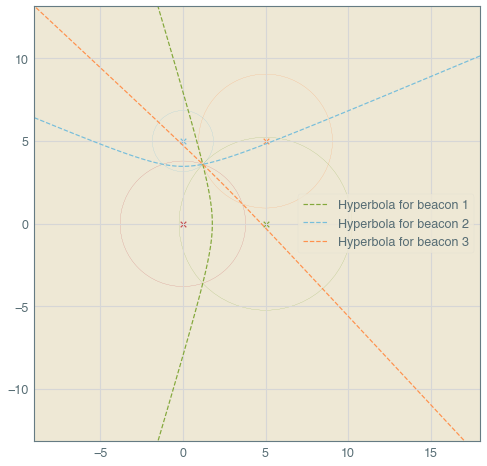

In [2]:
hyperbola_demo_1()

Solving for the intersection point of these hyperbolic equations in the plot above is computationally simple. However, real recorded signals will have error which will make an exact solution for all the beacons impossible. Least squares can be used to solve for the solution with the minimum amount of error, however this becomes mathematically difficult for non-linear equations such as our hyperbolas. Fortunately, we can linearize our system of equations to make least squares computationally simple and reliable.

**Getting $n-2$ linear equations:** Our hyperbolic solution in the previous section involves a square root we wish to get rid of. Observing that our non-linear term $\sqrt{x^2 + y^2}$ is independent of $x_m$ or $y_m$, we can sacrifice a beacon, $B_1$, to linearize our system:

$$ v_s\tau_m - v_s\tau_1 = \Bigg[\frac{-2x_mx + {x_m}^2 -2y_my + {y_m}^2}{v_s\tau_m} - 2\sqrt{x^2 + y^2}\Bigg] - \Bigg[\frac{-2x_1x + {x_1}^2 -2y_1y + {y_1}^2}{v_s\tau_1} - 2\sqrt{x^2 + y^2}\Bigg]$$

The subtraction removes the non-linear term. The final equation with respect to $B_m$ is ($m$ ranges from 2 to $n-1$): 

$$ \Bigg(\frac{2 x_m}{v_s\tau_m}-\frac{2 x_1}{v_s\tau_1}\Bigg)x + \Bigg(\frac{2 y_m}{v_s\tau_m}-\frac{2 y_1}{v_s\tau_1}\Bigg)y = \Bigg(\frac{{x_m}^2 + {y_m}^2}{v_s\tau_m} - \frac{{x_1}^2 + {y_1}^2}{v_s\tau_1}\Bigg) - \Bigg(v_s\tau_m - v_s\tau_1\Bigg)$$


Below is the same equation written out as a matrix for a system that has $M$ speakers. $x$ and $y$ are the coordinates of your speaker that you would like to solve for.

$$ \large
\begin{bmatrix}
    \frac{2 x_2}{v_s\tau_2}-\frac{2 x_1}{v_s\tau_1} & 
        \frac{2 y_2}{v_s\tau_2}-\frac{2 y_1}{v_s\tau_1} \\
    \frac{2 x_3}{v_s\tau_3}-\frac{2 x_1}{v_s\tau_1} & 
        \frac{2 y_3}{v_s\tau_3}-\frac{2 y_1}{v_s\tau_1} \\
    \vdots & 
        \vdots  \\
    \frac{2 x_m}{v_s\tau_m}-\frac{2 x_1}{v_s\tau_1} & 
        \frac{2 y_m}{v_s\tau_m}-\frac{2 y_1}{v_s\tau_1} \\
    \vdots &
        \vdots \\
    \frac{2 x_M}{v_s\tau_M}-\frac{2 x_1}{v_s\tau_1} & 
        \frac{2 y_M}{v_s\tau_M}-\frac{2 y_1}{v_s\tau_1} \\
\end{bmatrix}
\begin{bmatrix} 
    x \\  
    y 
\end{bmatrix} 
=
\begin{bmatrix} 
    (\frac{{x_2}^2 + {y_2}^2}{v_s\tau_2} - \frac{{x_1}^2 + {y_1}^2}{v_s\tau_1}) - (v_s\tau_2 - v_s\tau_1) \\
    (\frac{{x_3}^2 + {y_3}^2}{v_s\tau_3} - \frac{{x_1}^2 + {y_1}^2}{v_s\tau_1}) - (v_s\tau_3 - v_s\tau_1) \\
    \vdots \\
    (\frac{{x_m}^2 + {y_m}^2}{v_s\tau_m} - \frac{{x_1}^2 + {y_1}^2}{v_s\tau_1}) - (v_s\tau_m - v_s\tau_1) \\
    \vdots \\
    (\frac{{x_M}^2 + {y_M}^2}{v_s\tau_M} - \frac{{x_1}^2 + {y_1}^2}{v_s\tau_1}) - (v_s\tau_M - v_s\tau_1) 
\end{bmatrix}
$$

The result is a linear equation with our position as linear variables.

**<span style="color:red">
What is the minimum number of beacons we need in order to be able to recover a position from our system?
</span>**

**`4`**

Run the code below to plot the speakers of our system.

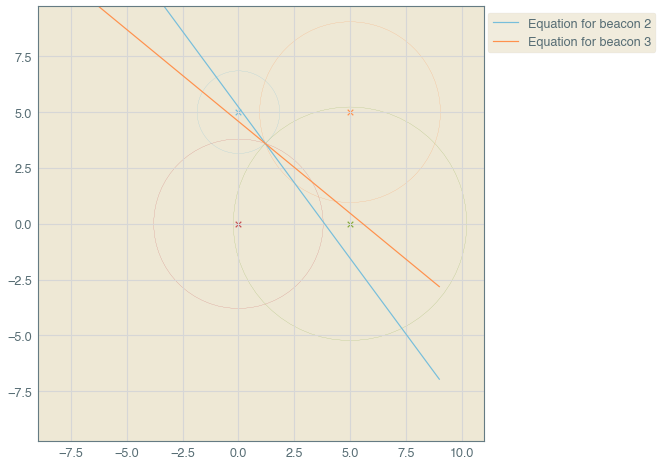

In [3]:
plot_speakers_demo()

As we see in the above example, the microphone's position lies on the intersection of the curves. Finding the position of the microphone is equivalent to finding the solution for the linear system.

**<span style="color:red">
Is our actual positioning system setup in this lab overdetermined or underdetermined? You may want to look at the presentation for APS 2 on the course website for a picture of the setup. Is this good or bad?
</span>**

**`it is overdetermined and it is good`**

**<span style="color:red">
Compare those two approaches (linear vs. hyperbolic equations). Which approach would be easier to implement?
</span>**

**`linear`**

Reference (and more reading!): http://en.wikipedia.org/wiki/Multilateration

<a id='task1'></a>
# <span style="color:blue">Task 1: Constructing the System of Equations</span>

Once we find the equations for each speaker and the microphone, we are able to construct a system of linear equations.

**<span style="color:red"> Write the function below that sets up the least squares problem. While the code block is large and may seem complex, the subfunctions that you have to fill in are much simpler. If you find yourself stuck, try fulfilling the exact requirements of the function you are working on, while ignoring the others.</span>**

For your convenience, the matrix equation is copied here:

$$ \large
\begin{bmatrix}
    \frac{2 x_2}{v_s\tau_2}-\frac{2 x_1}{v_s\tau_1} & 
        \frac{2 y_2}{v_s\tau_2}-\frac{2 y_1}{v_s\tau_1} \\
    \frac{2 x_3}{v_s\tau_3}-\frac{2 x_1}{v_s\tau_1} & 
        \frac{2 y_3}{v_s\tau_3}-\frac{2 y_1}{v_s\tau_1} \\
    \vdots & 
        \vdots  \\
    \frac{2 x_m}{v_s\tau_m}-\frac{2 x_1}{v_s\tau_1} & 
        \frac{2 y_m}{v_s\tau_m}-\frac{2 y_1}{v_s\tau_1} \\
    \vdots &
        \vdots \\
    \frac{2 x_M}{v_s\tau_M}-\frac{2 x_1}{v_s\tau_1} & 
        \frac{2 y_M}{v_s\tau_M}-\frac{2 y_1}{v_s\tau_1} \\
\end{bmatrix}
\begin{bmatrix} 
    x \\  
    y 
\end{bmatrix} 
=
\begin{bmatrix} 
    (\frac{{x_2}^2 + {y_2}^2}{v_s\tau_2} - \frac{{x_1}^2 + {y_1}^2}{v_s\tau_1}) - (v_s\tau_2 - v_s\tau_1) \\
    (\frac{{x_3}^2 + {y_3}^2}{v_s\tau_3} - \frac{{x_1}^2 + {y_1}^2}{v_s\tau_1}) - (v_s\tau_3 - v_s\tau_1) \\
    \vdots \\
    (\frac{{x_m}^2 + {y_m}^2}{v_s\tau_m} - \frac{{x_1}^2 + {y_1}^2}{v_s\tau_1}) - (v_s\tau_m - v_s\tau_1) \\
    \vdots \\
    (\frac{{x_M}^2 + {y_M}^2}{v_s\tau_M} - \frac{{x_1}^2 + {y_1}^2}{v_s\tau_1}) - (v_s\tau_M - v_s\tau_1) 
\end{bmatrix}
$$

In [8]:
def construct_system(speakers, TDOA, isac=1, plot=0):
    """Construct the components of the system according to a list of TDOA's
    Args:
    TDOA (np.array): an array of TDOA's
    isac : index of speaker to be sacrificed for linearization
    
    Returns:
    A (np.matrix): the matrix corresponding to the least squares system
    b (np.array): the vector corresponding to the least squares system
    
    YOUR TASK:
    1. Read over the doc strings to understand how the helper functions are to be implemented
    2. Using the matrix system above as a reference, complete helpers x, y, and b
    3. Take note of x_sac, y_sac, and t_sac below; think about how they can be used in the helper functions
    4. Using your helper functions, complete "BUILDING THE SYSTEM" to make A and b
    """
    x_sac, y_sac = speakers[isac]
    t_sac = TDOA[isac]
    v_s = 340.29
    
    def helperx(i):
        """Calculates the value for a row in the left column of the A matrix
        Arg:
        i : index of speaker to be used for the calculation
        
        Useful Variables: 
        speakers[i] : returns x_i, y_i (see x_sac and y_sac above for an example)
        TDOA[i] : returns t_i 
        
        Returns:
        A[i, 0]'s calculated out value
        """
        # YOUR CODE HERE
        x, _ = speakers[i]
        t = TDOA[i]
        return 2 / v_s * (x / t - x_sac / t_sac)
        
    
    def helpery(i):
        """Calculates the value for a row in the right column of the A matrix
        Arg:
        i : index of speaker to be used for the calculation
        
        Useful Variables: 
        speakers[i] : returns x_i, y_i (see x_sac and y_sac above for an example)
        TDOA[i] : returns t_i 
        
        Returns:
        A[i, 1]'s calculated out value
        """
        # YOUR CODE HERE
        _, y = speakers[i]
        t = TDOA[i]
        return 2 / v_s * (y / t - y_sac / t_sac)
        
    def helperb(i):
        """Calculates the ith value of the b vector
        Arg:
        i : index of speaker to be used for calculation
        
        Useful Variables: 
        speakers[i] : returns x_i, y_i (see x_sac and y_sac above for an example)
        TDOA[i] : returns t_i 
        
        Returns:
        b[i]'s calculated out value
        """
        # YOUR CODE HERE
        x, y = speakers[i]
        t = TDOA[i]
        tmp1 = (x ** 2 + y ** 2) / t
        tmp2 = (x_sac ** 2 + y_sac ** 2) / t_sac
        return (tmp1 - tmp2) / v_s - v_s * (t - t_sac)
    
    # BUILDING THE SYSTEM
    A, b = [], []
    for i in range(1, len(TDOA)):
        if (i!=isac): #if i is not the index of the beacon to be sacrificed, add elements to A and b
            # YOUR CODE HERE
            A += [[helperx(i), helpery(i)]]
            b += [helperb(i)]
            
            
            
    # PLOTTING
    if plot==1: #plot the linear equations
        x = np.linspace(-9, 9, 1000)
        for i in range(len(b)):
            y = [(b[i] - A[i][0]*xi) / A[i][1] for xi in x]
            plt.plot(x, y, label="Equation" + str(i + 1))   
        plt.xlim(-9, 9)
        plt.ylim(-6, 6)
        plt.legend()
        plt.show()
        
    # NORMALIZATIONS
    AA, bb = [], []
    for i in range(len(A)):
        AA.append([A[i][0]/np.linalg.norm(A[i]), A[i][1]/np.linalg.norm(A[i])])
        bb.append(b[i]/np.linalg.norm(A[i]))  
        
    return np.array(AA), np.array(bb)

Take a look at your results and make sure it works correctly (Don't worry if there are some small errors on order of +/- 0.5):

In [9]:
construct_system_test(construct_system)

Row 0: -3 should equal -3
Row 1: 4 should equal 4
Row 2: -2 should equal -2
Row 3: 1 should equal 1


$$ \large
\begin{bmatrix}
    \frac{2 x_2}{v_s\tau_2}-\frac{2 x_1}{v_s\tau_1} & 
        \frac{2 y_2}{v_s\tau_2}-\frac{2 y_1}{v_s\tau_1} \\
    \frac{2 x_3}{v_s\tau_3}-\frac{2 x_1}{v_s\tau_1} & 
        \frac{2 y_3}{v_s\tau_3}-\frac{2 y_1}{v_s\tau_1} \\
    \vdots & 
        \vdots  \\
    \frac{2 x_m}{v_s\tau_m}-\frac{2 x_1}{v_s\tau_1} & 
        \frac{2 y_m}{v_s\tau_m}-\frac{2 y_1}{v_s\tau_1} \\
    \vdots &
        \vdots \\
    \frac{2 x_M}{v_s\tau_M}-\frac{2 x_1}{v_s\tau_1} & 
        \frac{2 y_M}{v_s\tau_M}-\frac{2 y_1}{v_s\tau_1} \\
\end{bmatrix}
\begin{bmatrix} 
    x \\  
    y 
\end{bmatrix} 
=
\begin{bmatrix} 
    (\frac{{x_2}^2 + {y_2}^2}{v_s\tau_2} - \frac{{x_1}^2 + {y_1}^2}{v_s\tau_1}) - (v_s\tau_2 - v_s\tau_1) \\
    (\frac{{x_3}^2 + {y_3}^2}{v_s\tau_3} - \frac{{x_1}^2 + {y_1}^2}{v_s\tau_1}) - (v_s\tau_3 - v_s\tau_1) \\
    \vdots \\
    (\frac{{x_m}^2 + {y_m}^2}{v_s\tau_m} - \frac{{x_1}^2 + {y_1}^2}{v_s\tau_1}) - (v_s\tau_m - v_s\tau_1) \\
    \vdots \\
    (\frac{{x_M}^2 + {y_M}^2}{v_s\tau_M} - \frac{{x_1}^2 + {y_1}^2}{v_s\tau_1}) - (v_s\tau_M - v_s\tau_1) 
\end{bmatrix}
$$

Looking at the matrix form of our system, comment on the following:

**<span style="color:red">
Why does the first row of the matrix start at $m=2$? Why does it not make sense to start at $m=0$ or $1$?
</span>**

**`YOUR ANSWER HERE`**

**<span style="color:red">
What is the minimum number of rows that the matrix requires for this system to be solvable? Understanding how Linear Least Squares works, do we want more or exactly that many rows to get an accurate reading of our position?
</span>**

**`2`**

<a id='task2'></a>
# <span style="color:blue">Task 2: Using Least Squares</span>

**Definition**: If $A$ is an $m \times n$ matrix and $\vec{b}$ is in $\mathbb{R}^m$, a **least-squares solution** of $A\vec{x}=\vec{b}$ is an $\hat{\vec{x}}$ in $\mathbb{R}^n$ such that for all $\vec{x}$ in $\mathbb{R}^n$: $||\vec{b} - A\hat{\vec{x}}|| \leq ||\vec{b} - A\vec{x}||$.

The solution for an overdetermined problem is given by solving the normal equations: $A^TA\vec{x}=A^T\vec{b}$.

**Why do we need least-squares here?**

During the transmission of sound in air, some noise is added into the signal. Most of the time we don't receive the original signal perfectly; in other words, the linear system is no longer consistent due to the modified signal. Also in our positioning system, we have more than 2 linear equations to improve the accuracy. However with more equations, the linear system is more likely to be inconsistent. Least-squares solution ensures a best approximation we can get, even if there is technically no solution to the system.

**<span style="color:red">Implement the following function given arguments matrix A and vector b. Implement your own function of solving least-squares, do not use the least squares solver built into python. Make sure your code passes the test before moving on.</span>**

In [11]:
def least_squares(A, b):
    """Solve the least squares problem
    
    Args:
    A (np.array): the matrix in the least squares problem
    b (np.array): the vector in the least squares problem
    
    Returns:
    pos (np.array): the result of the least squares problem (x)    
    """

    # YOUR CODE HERE
    return np.linalg.inv(A.T @ A) @ A.T @ b
    
least_squares_test(least_squares)

Your results:  [3.5 1.4]
Correct results:  [3.5 1.4]


**<span style="color:red">Test your code with noisy inputs. Are all of the estimates in the cases with noise reasonable? Why or why not?</span>**
(This would take for a while to compute. Don't worry if there are some small errors on the order of +/- 0.1)

In [12]:
# Testing signals with noise
test_loc(least_squares, construct_system, 1.2, 3.6, 30)
test_loc(least_squares, construct_system, 1.2, 3.6, 40)
test_loc(least_squares, construct_system, 1.2, 3.6, 50)

Expected: (1.200, 3.600); got (1.209, 3.586)

Expected: (1.200, 3.600); got (1.201, 3.596)

Expected: (1.200, 3.600); got (1.193, 3.593)



<a id='task3a'></a>
# <span style="color:blue">Task 3a: Simulation Testing</span>

**<span style="color:red">You will go through a simulation to ensure that your code is working for a stable, slightly noisy simulation. Run the code below to test your code against our test signal. Your calculated position should be decently close to where we have placed the microphone. </span>**

Least Squares Position: -0.0011, 0.4011
Actual Simulation Microphone Position: (0, 0.4)
Distances from Speakers : [0.4011, 0.6635, 0.6712, 0.5709, 0.1619, 0.1002]



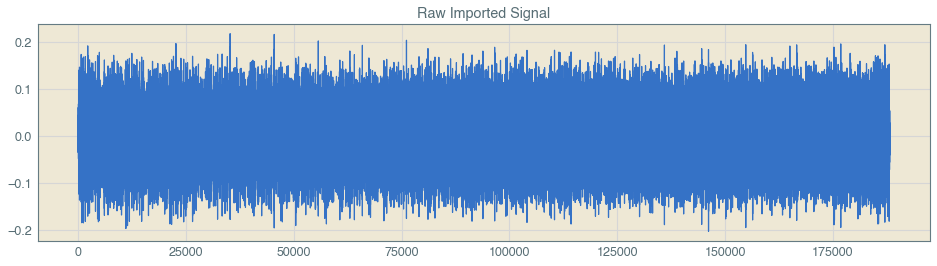

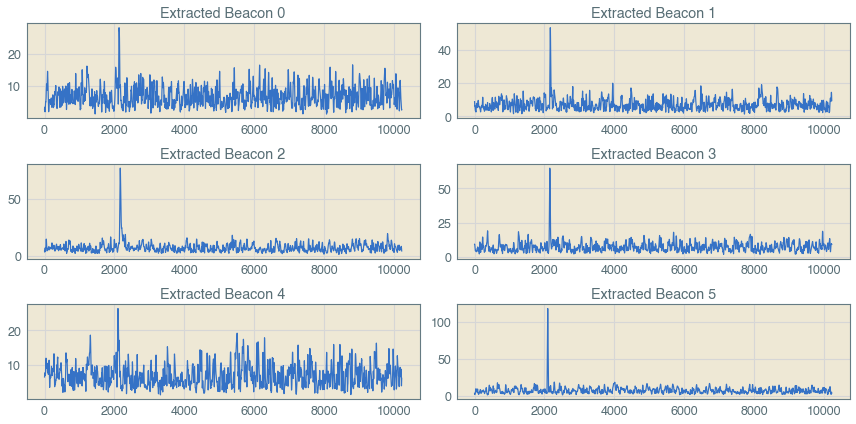

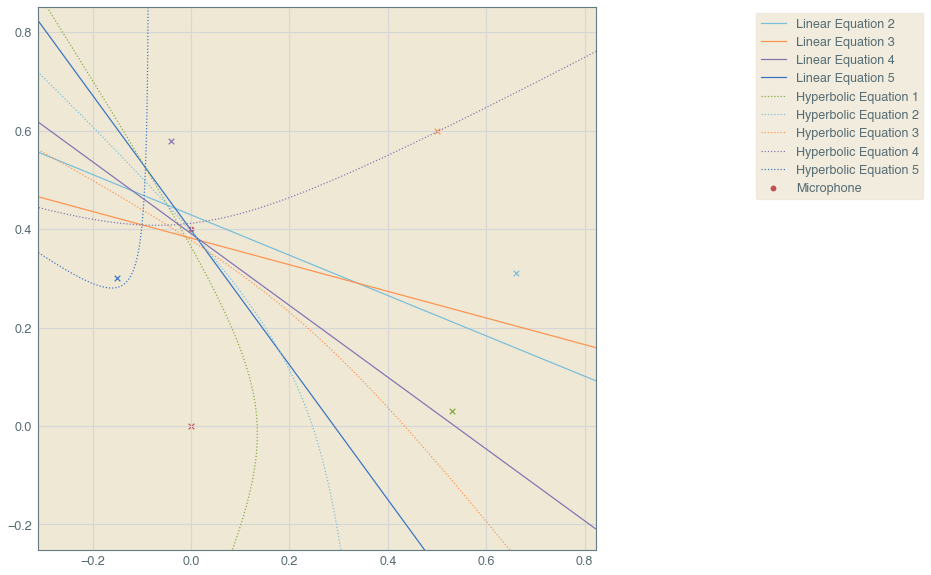

In [13]:
simulation_testing(construct_system, least_squares, 'test-signal.wav')

<a id='task3b'></a>
# <span style="color:blue">Task 3b: "Real Life" Positioning </span>

Now we are ready to determine speaker position in lab! 


**<span style="color:red">NOTE: bottom-right.wav and test-signal.wav are already included in the folder containing this notebook. You only need one file to complete this part, although you may and are encouraged to rerun the code with a different file.</span>**


If you wish to use a different file, download your chosen `.wav` file and move it to the same directory as this notebook. You can download a premade recording from [this folder](https://drive.google.com/drive/folders/1_ECVJ-nQkBN8FEisbswyP8keFNcqyeZm?usp=sharing). 

Run the cell below to see if your code can determine where you had "placed" your speaker. 

Type filename (including the .wav): bottom-right.wav
Least Squares Position: 0.4714, 0.1243
Distances from Speakers : [0.4875, 0.3409, 0.3717, 0.4952, 0.6187, 0.5878]



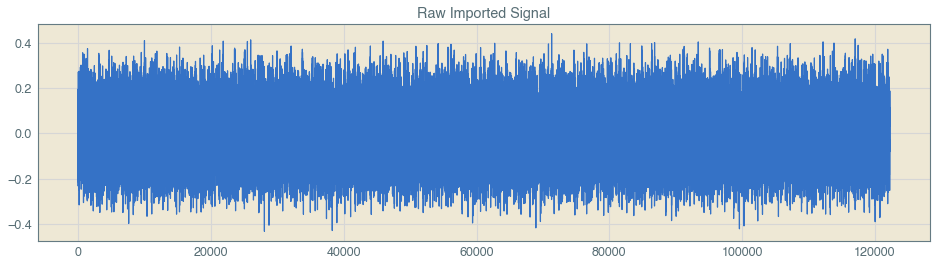

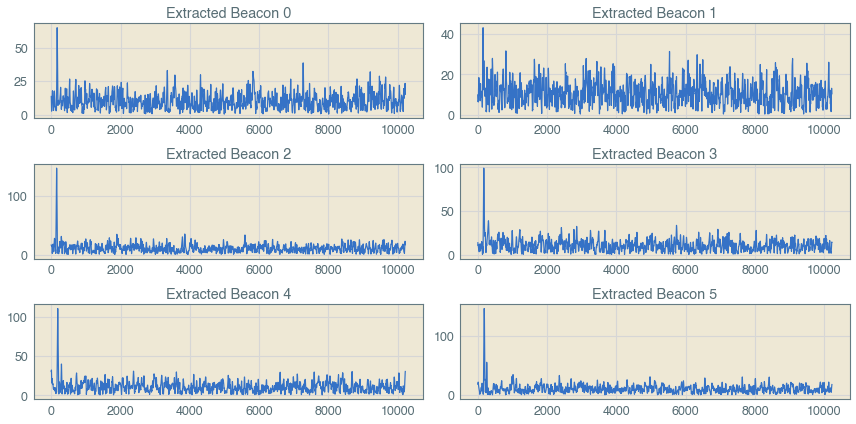

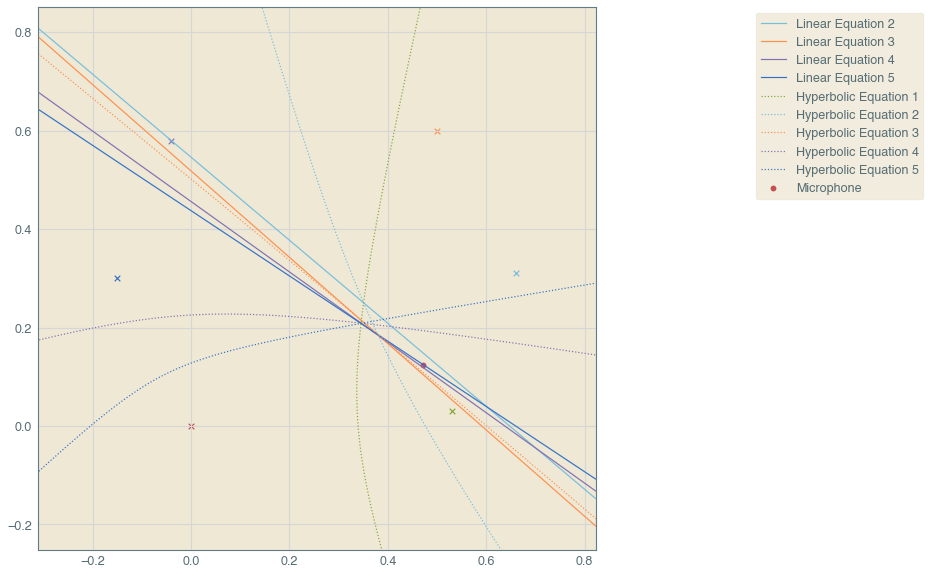

In [14]:
user_test(construct_system, least_squares)

## **Congratulations!**
You have successfully located a microphone using techniques learned in lecture.

<a id='checkoff'></a>
## Checkoff
When you are ready to get checked off,
1. Fill out the checkoff google form. **[Checkoff Form](https://forms.gle/TLjsE68kEf8QpcWa9)**
2. Submit a **checkoff** request on the lab queue. **[Checkoff queue](https://lab.eecs16a.org)** It is fine if only one person from your group submits the lab queue request, but everyone must submit their own google form. 

Your GSI or a Lab Assistant will join your breakout room when they are available and go through some checkoff questions with your group. They will go through the checkoff list in order. Please be patient!

## **<span style="color:red"> Please have your notebook ready to demo before being checked off. </span>**